In [1]:
from rdkit import Chem
import sys
import os
import useful_rdkit_utils as uru
from rdkit.Chem.Draw import MolsToGridImage
from rdkit.Chem.Scaffolds import MurckoScaffold
from rdkit.Chem import Descriptors
import matplotlib.pyplot as plt
import itertools
import pandas as pd
from collections import Counter
import mols2grid
from tdc.single_pred import ADME
from Filtering_functions import filter_molecules
import glob
import molvs
from multiprocessing import Pool, cpu_count
from tqdm.auto import tqdm

In [2]:
# Get the current working directory
current_dir = os.getcwd()
print(current_dir)
# Get the parent directory
parent_dir = os.path.abspath(os.path.join(current_dir, '..'))
print(parent_dir)
# Add the parent directory to sys.path
sys.path.append(parent_dir)

/home/yang2531/Documents/Bo_toolbox/PatWalters/Benchmarking_gene_model/Crossdock_datasets
/home/yang2531/Documents/Bo_toolbox/PatWalters/Benchmarking_gene_model


Reading data from crossdock dataset, add a standardization for small molecule data:

In [40]:
# # Function to read all SDF files and convert to mol objects
# def read_sdf_files_from_folders(main_folder):
#     mol_list = []

#     # Traverse the main folder and subfolders
#     for root, dirs, files in os.walk(main_folder):
#         for file in files:
#             # Check if the file is a .sdf file
#             if file.endswith(".sdf"):
#                 sdf_path = os.path.join(root, file)
                
#                 # Use RDKit to read the .sdf file
#                 supplier = Chem.SDMolSupplier(sdf_path)
                
#                 # Add each mol from the .sdf file to the list
#                 for mol in supplier:
#                     if mol is not None:  # Ensure mol is valid
#                         mol_list.append(mol)
    
#     return mol_list

# # Example usage
# main_folder = '/home/yang2531/Documents/Bo_toolbox/PatWalters/Benchmarking_gene_model/Crossdock_datasets'  # Replace with your folder path
# molecules = read_sdf_files_from_folders(main_folder)

# # You can now work with the list of mol objects
# print(f"Number of molecules read: {len(molecules)}")

In [3]:
standardizer = molvs.standardize.Standardizer()

def standardize_mol(mol):
    try:
        mol = standardizer.standardize(mol)
        mol = standardizer.fragment_parent(mol, skip_standardize=True)
        mol = standardizer.tautomer_parent(mol, skip_standardize=True)
        mol = standardizer.isotope_parent(mol, skip_standardize=True)
        mol = standardizer.charge_parent(mol, skip_standardize=True)
        return mol
    except:
        return None

In [4]:
smi_list = []
with open('/home/yang2531/Documents/Bo_toolbox/PatWalters/Benchmarking_gene_model/Crossdock_datasets/crossdock_ligand_smi.smi') as f:
    for smi in f:
        smi_list.append(smi.strip())
standardized_smiles_list = []
for smi in tqdm(smi_list, desc="Standardizing molecules", unit="mol"):
    mol = Chem.MolFromSmiles(smi)
    mol = standardize_mol(mol)
    
    if mol:
        standardized_smiles_list.append(Chem.MolToSmiles(mol))
    else:
        print(f"Skipping molecule {smi}")
        pass

print(len(smi_list))
len(standardized_smiles_list)

Standardizing molecules:   0%|          | 0/11315 [00:00<?, ?mol/s]

[15:46:17] Unusual charge on atom 0 number of radical electrons set to zero
[15:46:17] Unusual charge on atom 0 number of radical electrons set to zero
[15:46:17] Unusual charge on atom 0 number of radical electrons set to zero
[15:46:17] Unusual charge on atom 0 number of radical electrons set to zero
[15:46:17] Unusual charge on atom 0 number of radical electrons set to zero
[15:46:17] Unusual charge on atom 0 number of radical electrons set to zero
[15:46:17] Unusual charge on atom 0 number of radical electrons set to zero
[15:46:17] Unusual charge on atom 0 number of radical electrons set to zero
[15:46:17] Unusual charge on atom 0 number of radical electrons set to zero
[15:46:17] Unusual charge on atom 0 number of radical electrons set to zero
[15:46:17] Unusual charge on atom 0 number of radical electrons set to zero
[15:46:17] Unusual charge on atom 0 number of radical electrons set to zero
[15:46:17] Unusual charge on atom 0 number of radical electrons set to zero
[15:46:17] U

11315


11315

Set the default image size

In [5]:
with open('crossdock_ligand_smi_standardized.smi', 'w') as f:
    for item in standardized_smiles_list:
        f.write("%s\n" % item)

In [6]:
uru.rd_set_image_size(300,300)

Convert SMILES and name of them to a dataframe

In [7]:
df = pd.DataFrame(standardized_smiles_list, columns=['SMILES'])
df

SMILES
0      CCn1c(-c2no[nH]c2=N)nc2c(C#CC(C)(C)O)ncc(OC[C@...
1      N=c1[nH]cnc2c1ncn2[C@@H]1O[C@H](CO[PH](=O)(=O)...
2      N=c1[nH]cnc2c1ncn2[C@@H]1O[C@H](CO[PH](=O)(=O)...
3      N=c1[nH]cnc2c1ncn2[C@@H]1O[C@H](CO[PH](=O)(=O)...
4      COC(=O)[C@@]1(O)C[C@H]2O[C@]1(C)n1c3ccccc3c3c4...
...                                                  ...
11591                    C=C/C=C/[C@@]1(C)SC(=O)C(C)C1=O
11592                          NC[C@@H](O)c1ccc(O)c(O)c1
11593                                 NC(C=O)Cc1c[nH]cn1
11594  N=c1[nH]cnc2c1ncn2[C@@H]1O[C@H](COS(O)(O)NC(=O...
11595  N=c1[nH]cnc2c1ncn2[C@@H]1O[C@H](CO[PH](=O)(=O)...

[11596 rows x 1 columns]

Remove repeated molecules

In [8]:
df = df.drop_duplicates(['SMILES'])
df.reset_index(inplace=True, drop=True)
df

SMILES
0      CCn1c(-c2no[nH]c2=N)nc2c(C#CC(C)(C)O)ncc(OC[C@...
1      N=c1[nH]cnc2c1ncn2[C@@H]1O[C@H](CO[PH](=O)(=O)...
2      N=c1[nH]cnc2c1ncn2[C@@H]1O[C@H](CO[PH](=O)(=O)...
3      N=c1[nH]cnc2c1ncn2[C@@H]1O[C@H](CO[PH](=O)(=O)...
4      COC(=O)[C@@]1(O)C[C@H]2O[C@]1(C)n1c3ccccc3c3c4...
...                                                  ...
11310                      CC(=O)c1sc(=Nc2ccccc2)[nH]c1C
11311                    C=C/C=C/[C@@]1(C)SC(=O)C(C)C1=O
11312                          NC[C@@H](O)c1ccc(O)c(O)c1
11313                                 NC(C=O)Cc1c[nH]cn1
11314  N=c1[nH]cnc2c1ncn2[C@@H]1O[C@H](COS(O)(O)NC(=O...

[11315 rows x 1 columns]

Save the smi file for further use

In [9]:
smi_export_list = df['SMILES'].tolist()
with open('crossdock_ligand_smi.smi', 'w') as f:
    for item in smi_export_list:
        f.write("%s\n" % item)

Add an RDKit molecule to the dataframe

In [10]:
df['mol'] = df.SMILES.apply(Chem.MolFromSmiles)

[16:03:39] Unusual charge on atom 0 number of radical electrons set to zero


Strip salts from the molecule

[16:03:47] Unusual charge on atom 0 number of radical electrons set to zero


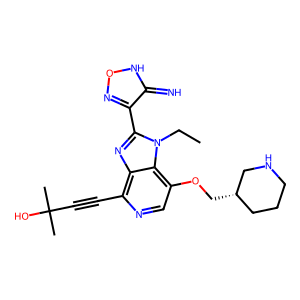

In [11]:
df.mol = df.mol.apply(uru.get_largest_fragment)
df.mol[0]

Instantiate a RingSystemFinder object and find ring systems for the molecules in df

In [12]:
ring_system_finder = uru.RingSystemFinder()
df['ring_sytems'] = df.mol.apply(ring_system_finder.find_ring_systems)
df.ring_sytems

[16:03:57] Unusual charge on atom 0 number of radical electrons set to zero


0               [c1cc2[nH]cnc2cn1, N=c1cno[nH]1, C1CCNCC1]
1                         [N=c1[nH]cnc2[nH]cnc12, C1CCOC1]
2                         [N=c1[nH]cnc2[nH]cnc12, C1CCOC1]
3                         [N=c1[nH]cnc2[nH]cnc12, C1CCOC1]
4        [O=C1N=Cc2c1c1c3ccccc3n3c1c1c2c2ccccc2n1[C@@H]...
                               ...                        
11310                             [N=c1[nH]ccs1, c1ccccc1]
11311                                      [O=C1CSC(=O)C1]
11312                                           [c1ccccc1]
11313                                         [c1c[nH]cn1]
11314         [N=c1[nH]cnc2[nH]cnc12, C1CCOC1, c1c[nH]cn1]
Name: ring_sytems, Length: 11315, dtype: object

In [13]:
df.ring_sytems.values

array([list(['c1cc2[nH]cnc2cn1', 'N=c1cno[nH]1', 'C1CCNCC1']),
       list(['N=c1[nH]cnc2[nH]cnc12', 'C1CCOC1']),
       list(['N=c1[nH]cnc2[nH]cnc12', 'C1CCOC1']), ...,
       list(['c1ccccc1']), list(['c1c[nH]cn1']),
       list(['N=c1[nH]cnc2[nH]cnc12', 'C1CCOC1', 'c1c[nH]cn1'])],
      dtype=object)

See how many times each ring system occurs

In [14]:
ring_system_list = list(itertools.chain.from_iterable(df.ring_sytems.values))
ring_count_df = pd.DataFrame(Counter(ring_system_list).items(),columns=["SMILES","Count"]) ### Convert a dictionary to a DataFrame.
ring_count_df.sort_values("Count",ascending=False,inplace=True)
ring_count_df

SMILES  Count
7                                              c1ccccc1   8817
10                                             c1ccncc1    854
4                                               C1CCOC1    656
2                                              C1CCNCC1    622
8                                              C1CCOCC1    528
...                                                 ...    ...
1215     N=c1nc2cc([nH]1)-c1cccc(c1)C(=O)NCCCNC(=O)CCS2      1
1214                      O=C1CCCc2c1cc1n2-c2ccccc2NCC1      1
1213                                    C1=NCNc2ccccc21      1
1212                              C=C1N=NC2CC(=O)C=CC12      1
525   O=C1NC2(CC2)C(=O)NS(=O)(=O)c2ccccc2NCCCCCCCCC(...      1

[2052 rows x 2 columns]

View the ring system frequencies

In [15]:
mols2grid.display(ring_count_df,subset=["img","Count"])

MolGridWidget()

The RingSystemLookup object has a dictionary of how many times each ring system occurs in the ChEMBL database.  We can use this object to evaluate the molecules in df.

In [16]:
ring_system_lookup = uru.RingSystemLookup()
res = df.mol.apply(ring_system_lookup.process_mol)

[16:04:19] Unusual charge on atom 0 number of radical electrons set to zero
[16:04:25] unrecognized chirality tag (6) on atom 7 is ignored.
[16:04:28] unrecognized chirality tag (6) on atom 1 is ignored.


In [17]:
res

0        [(c1cc2[nH]cnc2cn1, 2743), (N=c1cno[nH]1, 0), ...
1          [(N=c1[nH]cnc2[nH]cnc12, 30), (C1CCOC1, 54820)]
2          [(N=c1[nH]cnc2[nH]cnc12, 30), (C1CCOC1, 54820)]
3          [(N=c1[nH]cnc2[nH]cnc12, 30), (C1CCOC1, 54820)]
4        [(O=C1N=Cc2c1c1c3ccccc3n3c1c1c2c2ccccc2n1[C@@H...
                               ...                        
11310          [(N=c1[nH]ccs1, 1506), (c1ccccc1, 2568039)]
11311                                 [(O=C1CSC(=O)C1, 9)]
11312                                [(c1ccccc1, 2568039)]
11313                                [(c1c[nH]cn1, 78586)]
11314    [(N=c1[nH]cnc2[nH]cnc12, 30), (C1CCOC1, 54820)...
Name: mol, Length: 11315, dtype: object

In [18]:
df[['min_ring','min_freq']] = res.apply(uru.get_min_ring_frequency).tolist()
df

SMILES  \
0      CCn1c(-c2no[nH]c2=N)nc2c(C#CC(C)(C)O)ncc(OC[C@...   
1      N=c1[nH]cnc2c1ncn2[C@@H]1O[C@H](CO[PH](=O)(=O)...   
2      N=c1[nH]cnc2c1ncn2[C@@H]1O[C@H](CO[PH](=O)(=O)...   
3      N=c1[nH]cnc2c1ncn2[C@@H]1O[C@H](CO[PH](=O)(=O)...   
4      COC(=O)[C@@]1(O)C[C@H]2O[C@]1(C)n1c3ccccc3c3c4...   
...                                                  ...   
11310                      CC(=O)c1sc(=Nc2ccccc2)[nH]c1C   
11311                    C=C/C=C/[C@@]1(C)SC(=O)C(C)C1=O   
11312                          NC[C@@H](O)c1ccc(O)c(O)c1   
11313                                 NC(C=O)Cc1c[nH]cn1   
11314  N=c1[nH]cnc2c1ncn2[C@@H]1O[C@H](COS(O)(O)NC(=O...   

                                                    mol  \
0      <rdkit.Chem.rdchem.Mol object at 0x70f4a3f71380>   
1      <rdkit.Chem.rdchem.Mol object at 0x70f4a3d38580>   
2      <rdkit.Chem.rdchem.Mol object at 0x70f4a3d385f0>   
3      <rdkit.Chem.rdchem.Mol object at 0x70f4a3d38660>   
4      <rdkit.Chem.rdchem.Mol object at 0x70f4a3d386d0>   
...                                                 ...   
11310  <rdkit.Chem.rdchem.Mol object at 0x70f4a3c704a0>   
11311  <rdkit.Chem.rdchem.Mol object at 0x70f4a3c70510>   
11312  <rdkit.Chem.rdchem.Mol object at 0x70f4a3c70580>   
11313  <rdkit.Chem.rdchem.Mol object at 0x70f4a3c705f0>   
11314  <rdkit.Chem.rdchem.Mol object at 0x70f4a3c70660>   

                                             ring_sytems  \
0             [c1cc2[nH]cnc2cn1, N=c1cno[nH]1, C1CCNCC1]   
1                       [N=c1[nH]cnc2[nH]cnc12, C1CCOC1]   
2                       [N=c1[nH]cnc2[nH]cnc12, C1CCOC1]   
3                       [N=c1[nH]cnc2[nH]cnc12, C1CCOC1]   
4      [O=C1N=Cc2c1c1c3ccccc3n3c1c1c2c2ccccc2n1[C@@H]...   
...                                                  ...   
11310                           [N=c1[nH]ccs1, c1ccccc1]   
11311                                    [O=C1CSC(=O)C1]   
11312                                         [c1ccccc1]   
11313                                       [c1c[nH]cn1]   
11314       [N=c1[nH]cnc2[nH]cnc12, C1CCOC1, c1c[nH]cn1]   

                                                min_ring min_freq  
0                                           N=c1cno[nH]1        0  
1                                  N=c1[nH]cnc2[nH]cnc12       30  
2                                  N=c1[nH]cnc2[nH]cnc12       30  
3                                  N=c1[nH]cnc2[nH]cnc12       30  
4      O=C1N=Cc2c1c1c3ccccc3n3c1c1c2c2ccccc2n1[C@@H]1...        0  
...                                                  ...      ...  
11310                                       N=c1[nH]ccs1     1506  
11311                                      O=C1CSC(=O)C1        9  
11312                                           c1ccccc1  2568039  
11313                                         c1c[nH]cn1    78586  
11314                              N=c1[nH]cnc2[nH]cnc12       30  

[11315 rows x 5 columns]

In [19]:
mols2grid.display(df.sort_values("min_freq"),mol_col="mol",subset=["img","min_freq"])

MolGridWidget()

### Check how many molecules are unique the ring frequency of them

How many molecules are unique using inChI?

In [20]:
df['inchi'] = df.mol.apply(Chem.MolToInchi)
df = df.drop_duplicates("inchi", keep="first", ignore_index=True)
df

[16:04:49] WARNING: Accepted unusual valence(s): P(6)

[16:04:49] WARNING: Accepted unusual valence(s): P(6)

[16:04:49] WARNING: Accepted unusual valence(s): P(6)

[16:04:49] WARNING: Charges were rearranged

[16:04:49] WARNING: Charges were rearranged

[16:04:49] WARNING: Charges were rearranged

[16:04:49] WARNING: Accepted unusual valence(s): P(6); Omitted undefined stereo

[16:04:49] WARNING: Accepted unusual valence(s): P(6)

[16:04:49] WARNING: Accepted unusual valence(s): P(6)

[16:04:49] WARNING: Accepted unusual valence(s): P(6)

[16:04:49] WARNING: Accepted unusual valence(s): P(6)

[16:04:49] WARNING: Accepted unusual valence(s): P(6); Omitted undefined stereo

[16:04:49] WARNING: Omitted undefined stereo

[16:04:49] WARNING: Omitted undefined stereo

[16:04:49] WARNING: Omitted undefined stereo

[16:04:49] WARNING: Omitted undefined stereo

[16:04:49] WARNING: Omitted undefined stereo

[16:04:49] WARNING: Omitted undefined stereo

[16:04:49] WARNING: Omitted undefined ster

SMILES  \
0      CCn1c(-c2no[nH]c2=N)nc2c(C#CC(C)(C)O)ncc(OC[C@...   
1      N=c1[nH]cnc2c1ncn2[C@@H]1O[C@H](CO[PH](=O)(=O)...   
2      N=c1[nH]cnc2c1ncn2[C@@H]1O[C@H](CO[PH](=O)(=O)...   
3      N=c1[nH]cnc2c1ncn2[C@@H]1O[C@H](CO[PH](=O)(=O)...   
4      COC(=O)[C@@]1(O)C[C@H]2O[C@]1(C)n1c3ccccc3c3c4...   
...                                                  ...   
11309                      CC(=O)c1sc(=Nc2ccccc2)[nH]c1C   
11310                    C=C/C=C/[C@@]1(C)SC(=O)C(C)C1=O   
11311                          NC[C@@H](O)c1ccc(O)c(O)c1   
11312                                 NC(C=O)Cc1c[nH]cn1   
11313  N=c1[nH]cnc2c1ncn2[C@@H]1O[C@H](COS(O)(O)NC(=O...   

                                                    mol  \
0      <rdkit.Chem.rdchem.Mol object at 0x70f4a3f71380>   
1      <rdkit.Chem.rdchem.Mol object at 0x70f4a3d38580>   
2      <rdkit.Chem.rdchem.Mol object at 0x70f4a3d385f0>   
3      <rdkit.Chem.rdchem.Mol object at 0x70f4a3d38660>   
4      <rdkit.Chem.rdchem.Mol object at 0x70f4a3d386d0>   
...                                                 ...   
11309  <rdkit.Chem.rdchem.Mol object at 0x70f4a3c704a0>   
11310  <rdkit.Chem.rdchem.Mol object at 0x70f4a3c70510>   
11311  <rdkit.Chem.rdchem.Mol object at 0x70f4a3c70580>   
11312  <rdkit.Chem.rdchem.Mol object at 0x70f4a3c705f0>   
11313  <rdkit.Chem.rdchem.Mol object at 0x70f4a3c70660>   

                                             ring_sytems  \
0             [c1cc2[nH]cnc2cn1, N=c1cno[nH]1, C1CCNCC1]   
1                       [N=c1[nH]cnc2[nH]cnc12, C1CCOC1]   
2                       [N=c1[nH]cnc2[nH]cnc12, C1CCOC1]   
3                       [N=c1[nH]cnc2[nH]cnc12, C1CCOC1]   
4      [O=C1N=Cc2c1c1c3ccccc3n3c1c1c2c2ccccc2n1[C@@H]...   
...                                                  ...   
11309                           [N=c1[nH]ccs1, c1ccccc1]   
11310                                    [O=C1CSC(=O)C1]   
11311                                         [c1ccccc1]   
11312                                       [c1c[nH]cn1]   
11313       [N=c1[nH]cnc2[nH]cnc12, C1CCOC1, c1c[nH]cn1]   

                                                min_ring min_freq  \
0                                           N=c1cno[nH]1        0   
1                                  N=c1[nH]cnc2[nH]cnc12       30   
2                                  N=c1[nH]cnc2[nH]cnc12       30   
3                                  N=c1[nH]cnc2[nH]cnc12       30   
4      O=C1N=Cc2c1c1c3ccccc3n3c1c1c2c2ccccc2n1[C@@H]1...        0   
...                                                  ...      ...   
11309                                       N=c1[nH]ccs1     1506   
11310                                      O=C1CSC(=O)C1        9   
11311                                           c1ccccc1  2568039   
11312                                         c1c[nH]cn1    78586   
11313                              N=c1[nH]cnc2[nH]cnc12       30   

                                                   inchi  
0      InChI=1S/C21H27N7O3/c1-4-28-18-15(30-12-13-6-5...  
1      InChI=1S/C10H13N5O12P3S/c11-8-5-9(13-2-12-8)15...  
2      InChI=1S/C10H13N5O12P3S/c11-8-5-9(13-2-12-8)15...  
3      InChI=1S/C10H13N5O10P2/c11-8-5-9(13-2-12-8)15(...  
4      InChI=1S/C27H19N3O5/c1-26-27(33,25(32)34-2)11-...  
...                                                  ...  
11309  InChI=1S/C12H12N2OS/c1-8-11(9(2)15)16-12(13-8)...  
11310  InChI=1S/C10H12O2S/c1-4-5-6-10(3)8(11)7(2)9(12...  
11311  InChI=1S/C8H11NO3/c9-4-8(12)5-1-2-6(10)7(11)3-...  
11312  InChI=1S/C6H9N3O/c7-5(3-10)1-6-2-8-4-9-6/h2-5H...  
11313  InChI=1S/C16H23N9O7S/c17-8(1-7-2-19-4-20-7)15(...  

[11314 rows x 6 columns]

How many of them have ring system?

In [21]:
df_ring = df[df.min_freq != -1]
df_ring

SMILES  \
0      CCn1c(-c2no[nH]c2=N)nc2c(C#CC(C)(C)O)ncc(OC[C@...   
1      N=c1[nH]cnc2c1ncn2[C@@H]1O[C@H](CO[PH](=O)(=O)...   
2      N=c1[nH]cnc2c1ncn2[C@@H]1O[C@H](CO[PH](=O)(=O)...   
3      N=c1[nH]cnc2c1ncn2[C@@H]1O[C@H](CO[PH](=O)(=O)...   
4      COC(=O)[C@@]1(O)C[C@H]2O[C@]1(C)n1c3ccccc3c3c4...   
...                                                  ...   
11309                      CC(=O)c1sc(=Nc2ccccc2)[nH]c1C   
11310                    C=C/C=C/[C@@]1(C)SC(=O)C(C)C1=O   
11311                          NC[C@@H](O)c1ccc(O)c(O)c1   
11312                                 NC(C=O)Cc1c[nH]cn1   
11313  N=c1[nH]cnc2c1ncn2[C@@H]1O[C@H](COS(O)(O)NC(=O...   

                                                    mol  \
0      <rdkit.Chem.rdchem.Mol object at 0x70f4a3f71380>   
1      <rdkit.Chem.rdchem.Mol object at 0x70f4a3d38580>   
2      <rdkit.Chem.rdchem.Mol object at 0x70f4a3d385f0>   
3      <rdkit.Chem.rdchem.Mol object at 0x70f4a3d38660>   
4      <rdkit.Chem.rdchem.Mol object at 0x70f4a3d386d0>   
...                                                 ...   
11309  <rdkit.Chem.rdchem.Mol object at 0x70f4a3c704a0>   
11310  <rdkit.Chem.rdchem.Mol object at 0x70f4a3c70510>   
11311  <rdkit.Chem.rdchem.Mol object at 0x70f4a3c70580>   
11312  <rdkit.Chem.rdchem.Mol object at 0x70f4a3c705f0>   
11313  <rdkit.Chem.rdchem.Mol object at 0x70f4a3c70660>   

                                             ring_sytems  \
0             [c1cc2[nH]cnc2cn1, N=c1cno[nH]1, C1CCNCC1]   
1                       [N=c1[nH]cnc2[nH]cnc12, C1CCOC1]   
2                       [N=c1[nH]cnc2[nH]cnc12, C1CCOC1]   
3                       [N=c1[nH]cnc2[nH]cnc12, C1CCOC1]   
4      [O=C1N=Cc2c1c1c3ccccc3n3c1c1c2c2ccccc2n1[C@@H]...   
...                                                  ...   
11309                           [N=c1[nH]ccs1, c1ccccc1]   
11310                                    [O=C1CSC(=O)C1]   
11311                                         [c1ccccc1]   
11312                                       [c1c[nH]cn1]   
11313       [N=c1[nH]cnc2[nH]cnc12, C1CCOC1, c1c[nH]cn1]   

                                                min_ring min_freq  \
0                                           N=c1cno[nH]1        0   
1                                  N=c1[nH]cnc2[nH]cnc12       30   
2                                  N=c1[nH]cnc2[nH]cnc12       30   
3                                  N=c1[nH]cnc2[nH]cnc12       30   
4      O=C1N=Cc2c1c1c3ccccc3n3c1c1c2c2ccccc2n1[C@@H]1...        0   
...                                                  ...      ...   
11309                                       N=c1[nH]ccs1     1506   
11310                                      O=C1CSC(=O)C1        9   
11311                                           c1ccccc1  2568039   
11312                                         c1c[nH]cn1    78586   
11313                              N=c1[nH]cnc2[nH]cnc12       30   

                                                   inchi  
0      InChI=1S/C21H27N7O3/c1-4-28-18-15(30-12-13-6-5...  
1      InChI=1S/C10H13N5O12P3S/c11-8-5-9(13-2-12-8)15...  
2      InChI=1S/C10H13N5O12P3S/c11-8-5-9(13-2-12-8)15...  
3      InChI=1S/C10H13N5O10P2/c11-8-5-9(13-2-12-8)15(...  
4      InChI=1S/C27H19N3O5/c1-26-27(33,25(32)34-2)11-...  
...                                                  ...  
11309  InChI=1S/C12H12N2OS/c1-8-11(9(2)15)16-12(13-8)...  
11310  InChI=1S/C10H12O2S/c1-4-5-6-10(3)8(11)7(2)9(12...  
11311  InChI=1S/C8H11NO3/c9-4-8(12)5-1-2-6(10)7(11)3-...  
11312  InChI=1S/C6H9N3O/c7-5(3-10)1-6-2-8-4-9-6/h2-5H...  
11313  InChI=1S/C16H23N9O7S/c17-8(1-7-2-19-4-20-7)15(...  

[10638 rows x 6 columns]

In [22]:
filtered_df_ring_freq = df[df.min_freq > 100]
filtered_df_ring_freq

SMILES  \
5          O=C1c2cccc3c(NCCO)ccc(c23)C(=O)N1c1cccc(Br)c1   
6      O=[N+]([O-])c1ccc(O[C@@H]2O[C@H](CO)[C@@H](O)[...   
7      CC(=O)N[C@H]1[C@H](Oc2ccc([N+](=O)[O-])cc2)O[C...   
8      O=[N+]([O-])c1ccc(O[C@H]2O[C@H](CO)[C@@H](O)[C...   
10                        Cc1ncc(CO[PH](=O)(=O)O)c(C)c1O   
...                                                  ...   
11297  N=c1[nH]cnc2c1c(C#CCCCNC(=O)CCCCCCCCCO)cn2[C@H...   
11308  CN(CCCCc1ccccc1)CCC(O)([PH](=O)(=O)O)[PH](=O)(...   
11309                      CC(=O)c1sc(=Nc2ccccc2)[nH]c1C   
11311                          NC[C@@H](O)c1ccc(O)c(O)c1   
11312                                 NC(C=O)Cc1c[nH]cn1   

                                                    mol  \
5      <rdkit.Chem.rdchem.Mol object at 0x70f4a3d38740>   
6      <rdkit.Chem.rdchem.Mol object at 0x70f4a3d387b0>   
7      <rdkit.Chem.rdchem.Mol object at 0x70f4a3d38820>   
8      <rdkit.Chem.rdchem.Mol object at 0x70f4a3d38890>   
10     <rdkit.Chem.rdchem.Mol object at 0x70f4a3d38970>   
...                                                 ...   
11297  <rdkit.Chem.rdchem.Mol object at 0x70f4a3c6fed0>   
11308  <rdkit.Chem.rdchem.Mol object at 0x70f4a3c70430>   
11309  <rdkit.Chem.rdchem.Mol object at 0x70f4a3c704a0>   
11311  <rdkit.Chem.rdchem.Mol object at 0x70f4a3c70580>   
11312  <rdkit.Chem.rdchem.Mol object at 0x70f4a3c705f0>   

                                 ring_sytems                   min_ring  \
5      [O=C1NC(=O)c2cccc3cccc1c23, c1ccccc1]  O=C1NC(=O)c2cccc3cccc1c23   
6                       [c1ccccc1, C1CCOCC1]                   C1CCOCC1   
7                       [C1CCOCC1, c1ccccc1]                   C1CCOCC1   
8                       [c1ccccc1, C1CCOCC1]                   C1CCOCC1   
10                                [c1ccncc1]                   c1ccncc1   
...                                      ...                        ...   
11297       [N=c1[nH]cnc2[nH]ccc12, C1CCOC1]      N=c1[nH]cnc2[nH]ccc12   
11308                             [c1ccccc1]                   c1ccccc1   
11309               [N=c1[nH]ccs1, c1ccccc1]               N=c1[nH]ccs1   
11311                             [c1ccccc1]                   c1ccccc1   
11312                           [c1c[nH]cn1]                 c1c[nH]cn1   

      min_freq                                              inchi  
5         2404  InChI=1S/C20H15BrN2O3/c21-12-3-1-4-13(11-12)23...  
6        74445  InChI=1S/C12H15NO8/c14-5-8-9(15)10(16)11(17)12...  
7        74445  InChI=1S/C14H18N2O8/c1-7(18)15-11-13(20)12(19)...  
8        74445  InChI=1S/C12H15NO8/c14-5-8-9(15)10(16)11(17)12...  
10      275595  InChI=1S/C8H11NO5P/c1-5-7(4-14-15(11,12)13)3-9...  
...        ...                                                ...  
11297      104  InChI=1S/C26H39N5O14P3/c27-25-24-19(11-7-6-9-1...  
11308  2568039  InChI=1S/C14H23NO7P2/c1-15(11-6-5-9-13-7-3-2-4...  
11309     1506  InChI=1S/C12H12N2OS/c1-8-11(9(2)15)16-12(13-8)...  
11311  2568039  InChI=1S/C8H11NO3/c9-4-8(12)5-1-2-6(10)7(11)3-...  
11312    78586  InChI=1S/C6H9N3O/c7-5(3-10)1-6-2-8-4-9-6/h2-5H...  

[7364 rows x 6 columns]

### How many of them could pass PAINS filter?

Get a list of rules

In [23]:
reos = uru.REOS()
reos.get_available_rule_sets()

array(['Glaxo', 'Dundee', 'BMS', 'PAINS', 'SureChEMBL', 'MLSMR',
       'Inpharmatica', 'LINT'], dtype=object)

Get the currently active rule sets

In [24]:
reos.get_active_rule_sets()

array(['Glaxo'], dtype=object)

Set active rule set to PAINS

In [25]:
reos.set_active_rule_sets(['PAINS'])
reos.get_active_rule_sets()

array(['PAINS'], dtype=object)

Apply PAINS filter to unique mols

In [26]:
reos.pandas_mols(df.mol)

  0%|          | 0/11314 [00:00<?, ?it/s]

rule_set_name     description
0                ok              ok
1                ok              ok
2                ok              ok
3                ok              ok
4             PAINS      dyes5A(27)
...             ...             ...
11309            ok              ok
11310            ok              ok
11311         PAINS  catechol_A(92)
11312            ok              ok
11313            ok              ok

[11314 rows x 2 columns]

In [27]:
df_PAINS_filter = pd.concat([df, reos.pandas_mols(df.mol)], axis=1)
df_PAINS_filter = df_PAINS_filter[df_PAINS_filter.description == 'ok']
df_PAINS_filter

  0%|          | 0/11314 [00:00<?, ?it/s]

SMILES  \
0      CCn1c(-c2no[nH]c2=N)nc2c(C#CC(C)(C)O)ncc(OC[C@...   
1      N=c1[nH]cnc2c1ncn2[C@@H]1O[C@H](CO[PH](=O)(=O)...   
2      N=c1[nH]cnc2c1ncn2[C@@H]1O[C@H](CO[PH](=O)(=O)...   
3      N=c1[nH]cnc2c1ncn2[C@@H]1O[C@H](CO[PH](=O)(=O)...   
5          O=C1c2cccc3c(NCCO)ccc(c23)C(=O)N1c1cccc(Br)c1   
...                                                  ...   
11308  CN(CCCCc1ccccc1)CCC(O)([PH](=O)(=O)O)[PH](=O)(...   
11309                      CC(=O)c1sc(=Nc2ccccc2)[nH]c1C   
11310                    C=C/C=C/[C@@]1(C)SC(=O)C(C)C1=O   
11312                                 NC(C=O)Cc1c[nH]cn1   
11313  N=c1[nH]cnc2c1ncn2[C@@H]1O[C@H](COS(O)(O)NC(=O...   

                                                    mol  \
0      <rdkit.Chem.rdchem.Mol object at 0x70f4a3f71380>   
1      <rdkit.Chem.rdchem.Mol object at 0x70f4a3d38580>   
2      <rdkit.Chem.rdchem.Mol object at 0x70f4a3d385f0>   
3      <rdkit.Chem.rdchem.Mol object at 0x70f4a3d38660>   
5      <rdkit.Chem.rdchem.Mol object at 0x70f4a3d38740>   
...                                                 ...   
11308  <rdkit.Chem.rdchem.Mol object at 0x70f4a3c70430>   
11309  <rdkit.Chem.rdchem.Mol object at 0x70f4a3c704a0>   
11310  <rdkit.Chem.rdchem.Mol object at 0x70f4a3c70510>   
11312  <rdkit.Chem.rdchem.Mol object at 0x70f4a3c705f0>   
11313  <rdkit.Chem.rdchem.Mol object at 0x70f4a3c70660>   

                                        ring_sytems  \
0        [c1cc2[nH]cnc2cn1, N=c1cno[nH]1, C1CCNCC1]   
1                  [N=c1[nH]cnc2[nH]cnc12, C1CCOC1]   
2                  [N=c1[nH]cnc2[nH]cnc12, C1CCOC1]   
3                  [N=c1[nH]cnc2[nH]cnc12, C1CCOC1]   
5             [O=C1NC(=O)c2cccc3cccc1c23, c1ccccc1]   
...                                             ...   
11308                                    [c1ccccc1]   
11309                      [N=c1[nH]ccs1, c1ccccc1]   
11310                               [O=C1CSC(=O)C1]   
11312                                  [c1c[nH]cn1]   
11313  [N=c1[nH]cnc2[nH]cnc12, C1CCOC1, c1c[nH]cn1]   

                        min_ring min_freq  \
0                   N=c1cno[nH]1        0   
1          N=c1[nH]cnc2[nH]cnc12       30   
2          N=c1[nH]cnc2[nH]cnc12       30   
3          N=c1[nH]cnc2[nH]cnc12       30   
5      O=C1NC(=O)c2cccc3cccc1c23     2404   
...                          ...      ...   
11308                   c1ccccc1  2568039   
11309               N=c1[nH]ccs1     1506   
11310              O=C1CSC(=O)C1        9   
11312                 c1c[nH]cn1    78586   
11313      N=c1[nH]cnc2[nH]cnc12       30   

                                                   inchi rule_set_name  \
0      InChI=1S/C21H27N7O3/c1-4-28-18-15(30-12-13-6-5...            ok   
1      InChI=1S/C10H13N5O12P3S/c11-8-5-9(13-2-12-8)15...            ok   
2      InChI=1S/C10H13N5O12P3S/c11-8-5-9(13-2-12-8)15...            ok   
3      InChI=1S/C10H13N5O10P2/c11-8-5-9(13-2-12-8)15(...            ok   
5      InChI=1S/C20H15BrN2O3/c21-12-3-1-4-13(11-12)23...            ok   
...                                                  ...           ...   
11308  InChI=1S/C14H23NO7P2/c1-15(11-6-5-9-13-7-3-2-4...            ok   
11309  InChI=1S/C12H12N2OS/c1-8-11(9(2)15)16-12(13-8)...            ok   
11310  InChI=1S/C10H12O2S/c1-4-5-6-10(3)8(11)7(2)9(12...            ok   
11312  InChI=1S/C6H9N3O/c7-5(3-10)1-6-2-8-4-9-6/h2-5H...            ok   
11313  InChI=1S/C16H23N9O7S/c17-8(1-7-2-19-4-20-7)15(...            ok   

      description  
0              ok  
1              ok  
2              ok  
3              ok  
5              ok  
...           ...  
11308          ok  
11309          ok  
11310          ok  
11312          ok  
11313          ok  

[10890 rows x 8 columns]

Test all filters from rd filters

In [28]:
rd_filters = ['Glaxo', 'Dundee', 'BMS', 'SureChEMBL', 'MLSMR', 'Inpharmatica', 'LINT']
for filter in rd_filters:
    reos.set_active_rule_sets([filter])
    new_df = reos.pandas_mols(df.mol)
    print(filter, len(new_df[new_df.description == "ok"])/len(new_df), reos.get_active_rule_sets(), len(new_df[new_df.description == "ok"]))

  0%|          | 0/11314 [00:00<?, ?it/s]

Glaxo 0.9454657945907725 ['Glaxo'] 10697


  0%|          | 0/11314 [00:00<?, ?it/s]

Dundee 0.5490542690471981 ['Dundee'] 6212


  0%|          | 0/11314 [00:00<?, ?it/s]

BMS 0.8733427611808379 ['BMS'] 9881


  0%|          | 0/11314 [00:00<?, ?it/s]

SureChEMBL 0.8017500441930352 ['SureChEMBL'] 9071


  0%|          | 0/11314 [00:00<?, ?it/s]

MLSMR 0.5539155029167403 ['MLSMR'] 6267


  0%|          | 0/11314 [00:00<?, ?it/s]

Inpharmatica 0.791497260031819 ['Inpharmatica'] 8955


  0%|          | 0/11314 [00:00<?, ?it/s]

LINT 0.5973130634611985 ['LINT'] 6758


### How many of them could pass filters suggested by Dr.Reymond?

In [29]:
df['Reymond'] = df.mol.apply(filter_molecules)
df

SMILES  \
0      CCn1c(-c2no[nH]c2=N)nc2c(C#CC(C)(C)O)ncc(OC[C@...   
1      N=c1[nH]cnc2c1ncn2[C@@H]1O[C@H](CO[PH](=O)(=O)...   
2      N=c1[nH]cnc2c1ncn2[C@@H]1O[C@H](CO[PH](=O)(=O)...   
3      N=c1[nH]cnc2c1ncn2[C@@H]1O[C@H](CO[PH](=O)(=O)...   
4      COC(=O)[C@@]1(O)C[C@H]2O[C@]1(C)n1c3ccccc3c3c4...   
...                                                  ...   
11309                      CC(=O)c1sc(=Nc2ccccc2)[nH]c1C   
11310                    C=C/C=C/[C@@]1(C)SC(=O)C(C)C1=O   
11311                          NC[C@@H](O)c1ccc(O)c(O)c1   
11312                                 NC(C=O)Cc1c[nH]cn1   
11313  N=c1[nH]cnc2c1ncn2[C@@H]1O[C@H](COS(O)(O)NC(=O...   

                                                    mol  \
0      <rdkit.Chem.rdchem.Mol object at 0x70f4a3f71380>   
1      <rdkit.Chem.rdchem.Mol object at 0x70f4a3d38580>   
2      <rdkit.Chem.rdchem.Mol object at 0x70f4a3d385f0>   
3      <rdkit.Chem.rdchem.Mol object at 0x70f4a3d38660>   
4      <rdkit.Chem.rdchem.Mol object at 0x70f4a3d386d0>   
...                                                 ...   
11309  <rdkit.Chem.rdchem.Mol object at 0x70f4a3c704a0>   
11310  <rdkit.Chem.rdchem.Mol object at 0x70f4a3c70510>   
11311  <rdkit.Chem.rdchem.Mol object at 0x70f4a3c70580>   
11312  <rdkit.Chem.rdchem.Mol object at 0x70f4a3c705f0>   
11313  <rdkit.Chem.rdchem.Mol object at 0x70f4a3c70660>   

                                             ring_sytems  \
0             [c1cc2[nH]cnc2cn1, N=c1cno[nH]1, C1CCNCC1]   
1                       [N=c1[nH]cnc2[nH]cnc12, C1CCOC1]   
2                       [N=c1[nH]cnc2[nH]cnc12, C1CCOC1]   
3                       [N=c1[nH]cnc2[nH]cnc12, C1CCOC1]   
4      [O=C1N=Cc2c1c1c3ccccc3n3c1c1c2c2ccccc2n1[C@@H]...   
...                                                  ...   
11309                           [N=c1[nH]ccs1, c1ccccc1]   
11310                                    [O=C1CSC(=O)C1]   
11311                                         [c1ccccc1]   
11312                                       [c1c[nH]cn1]   
11313       [N=c1[nH]cnc2[nH]cnc12, C1CCOC1, c1c[nH]cn1]   

                                                min_ring min_freq  \
0                                           N=c1cno[nH]1        0   
1                                  N=c1[nH]cnc2[nH]cnc12       30   
2                                  N=c1[nH]cnc2[nH]cnc12       30   
3                                  N=c1[nH]cnc2[nH]cnc12       30   
4      O=C1N=Cc2c1c1c3ccccc3n3c1c1c2c2ccccc2n1[C@@H]1...        0   
...                                                  ...      ...   
11309                                       N=c1[nH]ccs1     1506   
11310                                      O=C1CSC(=O)C1        9   
11311                                           c1ccccc1  2568039   
11312                                         c1c[nH]cn1    78586   
11313                              N=c1[nH]cnc2[nH]cnc12       30   

                                                   inchi  Reymond  
0      InChI=1S/C21H27N7O3/c1-4-28-18-15(30-12-13-6-5...     True  
1      InChI=1S/C10H13N5O12P3S/c11-8-5-9(13-2-12-8)15...     True  
2      InChI=1S/C10H13N5O12P3S/c11-8-5-9(13-2-12-8)15...     True  
3      InChI=1S/C10H13N5O10P2/c11-8-5-9(13-2-12-8)15(...     True  
4      InChI=1S/C27H19N3O5/c1-26-27(33,25(32)34-2)11-...     True  
...                                                  ...      ...  
11309  InChI=1S/C12H12N2OS/c1-8-11(9(2)15)16-12(13-8)...     True  
11310  InChI=1S/C10H12O2S/c1-4-5-6-10(3)8(11)7(2)9(12...     True  
11311  InChI=1S/C8H11NO3/c9-4-8(12)5-1-2-6(10)7(11)3-...     True  
11312  InChI=1S/C6H9N3O/c7-5(3-10)1-6-2-8-4-9-6/h2-5H...     True  
11313  InChI=1S/C16H23N9O7S/c17-8(1-7-2-19-4-20-7)15(...     True  

[11314 rows x 7 columns]

In [30]:
df_Reymond_filter = df[df.Reymond == True]
df_Reymond_filter

SMILES  \
0      CCn1c(-c2no[nH]c2=N)nc2c(C#CC(C)(C)O)ncc(OC[C@...   
1      N=c1[nH]cnc2c1ncn2[C@@H]1O[C@H](CO[PH](=O)(=O)...   
2      N=c1[nH]cnc2c1ncn2[C@@H]1O[C@H](CO[PH](=O)(=O)...   
3      N=c1[nH]cnc2c1ncn2[C@@H]1O[C@H](CO[PH](=O)(=O)...   
4      COC(=O)[C@@]1(O)C[C@H]2O[C@]1(C)n1c3ccccc3c3c4...   
...                                                  ...   
11309                      CC(=O)c1sc(=Nc2ccccc2)[nH]c1C   
11310                    C=C/C=C/[C@@]1(C)SC(=O)C(C)C1=O   
11311                          NC[C@@H](O)c1ccc(O)c(O)c1   
11312                                 NC(C=O)Cc1c[nH]cn1   
11313  N=c1[nH]cnc2c1ncn2[C@@H]1O[C@H](COS(O)(O)NC(=O...   

                                                    mol  \
0      <rdkit.Chem.rdchem.Mol object at 0x70f4a3f71380>   
1      <rdkit.Chem.rdchem.Mol object at 0x70f4a3d38580>   
2      <rdkit.Chem.rdchem.Mol object at 0x70f4a3d385f0>   
3      <rdkit.Chem.rdchem.Mol object at 0x70f4a3d38660>   
4      <rdkit.Chem.rdchem.Mol object at 0x70f4a3d386d0>   
...                                                 ...   
11309  <rdkit.Chem.rdchem.Mol object at 0x70f4a3c704a0>   
11310  <rdkit.Chem.rdchem.Mol object at 0x70f4a3c70510>   
11311  <rdkit.Chem.rdchem.Mol object at 0x70f4a3c70580>   
11312  <rdkit.Chem.rdchem.Mol object at 0x70f4a3c705f0>   
11313  <rdkit.Chem.rdchem.Mol object at 0x70f4a3c70660>   

                                             ring_sytems  \
0             [c1cc2[nH]cnc2cn1, N=c1cno[nH]1, C1CCNCC1]   
1                       [N=c1[nH]cnc2[nH]cnc12, C1CCOC1]   
2                       [N=c1[nH]cnc2[nH]cnc12, C1CCOC1]   
3                       [N=c1[nH]cnc2[nH]cnc12, C1CCOC1]   
4      [O=C1N=Cc2c1c1c3ccccc3n3c1c1c2c2ccccc2n1[C@@H]...   
...                                                  ...   
11309                           [N=c1[nH]ccs1, c1ccccc1]   
11310                                    [O=C1CSC(=O)C1]   
11311                                         [c1ccccc1]   
11312                                       [c1c[nH]cn1]   
11313       [N=c1[nH]cnc2[nH]cnc12, C1CCOC1, c1c[nH]cn1]   

                                                min_ring min_freq  \
0                                           N=c1cno[nH]1        0   
1                                  N=c1[nH]cnc2[nH]cnc12       30   
2                                  N=c1[nH]cnc2[nH]cnc12       30   
3                                  N=c1[nH]cnc2[nH]cnc12       30   
4      O=C1N=Cc2c1c1c3ccccc3n3c1c1c2c2ccccc2n1[C@@H]1...        0   
...                                                  ...      ...   
11309                                       N=c1[nH]ccs1     1506   
11310                                      O=C1CSC(=O)C1        9   
11311                                           c1ccccc1  2568039   
11312                                         c1c[nH]cn1    78586   
11313                              N=c1[nH]cnc2[nH]cnc12       30   

                                                   inchi  Reymond  
0      InChI=1S/C21H27N7O3/c1-4-28-18-15(30-12-13-6-5...     True  
1      InChI=1S/C10H13N5O12P3S/c11-8-5-9(13-2-12-8)15...     True  
2      InChI=1S/C10H13N5O12P3S/c11-8-5-9(13-2-12-8)15...     True  
3      InChI=1S/C10H13N5O10P2/c11-8-5-9(13-2-12-8)15(...     True  
4      InChI=1S/C27H19N3O5/c1-26-27(33,25(32)34-2)11-...     True  
...                                                  ...      ...  
11309  InChI=1S/C12H12N2OS/c1-8-11(9(2)15)16-12(13-8)...     True  
11310  InChI=1S/C10H12O2S/c1-4-5-6-10(3)8(11)7(2)9(12...     True  
11311  InChI=1S/C8H11NO3/c9-4-8(12)5-1-2-6(10)7(11)3-...     True  
11312  InChI=1S/C6H9N3O/c7-5(3-10)1-6-2-8-4-9-6/h2-5H...     True  
11313  InChI=1S/C16H23N9O7S/c17-8(1-7-2-19-4-20-7)15(...     True  

[11294 rows x 7 columns]

### How many of them could pass RO5?

In [31]:
def passes_rule_of_five(smiles):
    """Determine if a molecule passes Lipinski's Rule of Five."""
    mol = Chem.MolFromSmiles(smiles)
    if mol:
        hbd = Descriptors.NumHDonors(mol)  # Hydrogen bond donors
        hba = Descriptors.NumHAcceptors(mol)  # Hydrogen bond acceptors
        mw = Descriptors.MolWt(mol)  # Molecular weight
        logp = Descriptors.MolLogP(mol)  # LogP
        
        # Check Lipinski's Rule of Five criteria
        if hbd <= 5 and hba <= 10 and mw <= 500 and logp <= 5:
            return True
    return False

df['Lipinski'] = df.SMILES.apply(passes_rule_of_five)
df

[16:08:48] Unusual charge on atom 0 number of radical electrons set to zero


SMILES  \
0      CCn1c(-c2no[nH]c2=N)nc2c(C#CC(C)(C)O)ncc(OC[C@...   
1      N=c1[nH]cnc2c1ncn2[C@@H]1O[C@H](CO[PH](=O)(=O)...   
2      N=c1[nH]cnc2c1ncn2[C@@H]1O[C@H](CO[PH](=O)(=O)...   
3      N=c1[nH]cnc2c1ncn2[C@@H]1O[C@H](CO[PH](=O)(=O)...   
4      COC(=O)[C@@]1(O)C[C@H]2O[C@]1(C)n1c3ccccc3c3c4...   
...                                                  ...   
11309                      CC(=O)c1sc(=Nc2ccccc2)[nH]c1C   
11310                    C=C/C=C/[C@@]1(C)SC(=O)C(C)C1=O   
11311                          NC[C@@H](O)c1ccc(O)c(O)c1   
11312                                 NC(C=O)Cc1c[nH]cn1   
11313  N=c1[nH]cnc2c1ncn2[C@@H]1O[C@H](COS(O)(O)NC(=O...   

                                                    mol  \
0      <rdkit.Chem.rdchem.Mol object at 0x70f4a3f71380>   
1      <rdkit.Chem.rdchem.Mol object at 0x70f4a3d38580>   
2      <rdkit.Chem.rdchem.Mol object at 0x70f4a3d385f0>   
3      <rdkit.Chem.rdchem.Mol object at 0x70f4a3d38660>   
4      <rdkit.Chem.rdchem.Mol object at 0x70f4a3d386d0>   
...                                                 ...   
11309  <rdkit.Chem.rdchem.Mol object at 0x70f4a3c704a0>   
11310  <rdkit.Chem.rdchem.Mol object at 0x70f4a3c70510>   
11311  <rdkit.Chem.rdchem.Mol object at 0x70f4a3c70580>   
11312  <rdkit.Chem.rdchem.Mol object at 0x70f4a3c705f0>   
11313  <rdkit.Chem.rdchem.Mol object at 0x70f4a3c70660>   

                                             ring_sytems  \
0             [c1cc2[nH]cnc2cn1, N=c1cno[nH]1, C1CCNCC1]   
1                       [N=c1[nH]cnc2[nH]cnc12, C1CCOC1]   
2                       [N=c1[nH]cnc2[nH]cnc12, C1CCOC1]   
3                       [N=c1[nH]cnc2[nH]cnc12, C1CCOC1]   
4      [O=C1N=Cc2c1c1c3ccccc3n3c1c1c2c2ccccc2n1[C@@H]...   
...                                                  ...   
11309                           [N=c1[nH]ccs1, c1ccccc1]   
11310                                    [O=C1CSC(=O)C1]   
11311                                         [c1ccccc1]   
11312                                       [c1c[nH]cn1]   
11313       [N=c1[nH]cnc2[nH]cnc12, C1CCOC1, c1c[nH]cn1]   

                                                min_ring min_freq  \
0                                           N=c1cno[nH]1        0   
1                                  N=c1[nH]cnc2[nH]cnc12       30   
2                                  N=c1[nH]cnc2[nH]cnc12       30   
3                                  N=c1[nH]cnc2[nH]cnc12       30   
4      O=C1N=Cc2c1c1c3ccccc3n3c1c1c2c2ccccc2n1[C@@H]1...        0   
...                                                  ...      ...   
11309                                       N=c1[nH]ccs1     1506   
11310                                      O=C1CSC(=O)C1        9   
11311                                           c1ccccc1  2568039   
11312                                         c1c[nH]cn1    78586   
11313                              N=c1[nH]cnc2[nH]cnc12       30   

                                                   inchi  Reymond  Lipinski  
0      InChI=1S/C21H27N7O3/c1-4-28-18-15(30-12-13-6-5...     True      True  
1      InChI=1S/C10H13N5O12P3S/c11-8-5-9(13-2-12-8)15...     True     False  
2      InChI=1S/C10H13N5O12P3S/c11-8-5-9(13-2-12-8)15...     True     False  
3      InChI=1S/C10H13N5O10P2/c11-8-5-9(13-2-12-8)15(...     True     False  
4      InChI=1S/C27H19N3O5/c1-26-27(33,25(32)34-2)11-...     True      True  
...                                                  ...      ...       ...  
11309  InChI=1S/C12H12N2OS/c1-8-11(9(2)15)16-12(13-8)...     True      True  
11310  InChI=1S/C10H12O2S/c1-4-5-6-10(3)8(11)7(2)9(12...     True      True  
11311  InChI=1S/C8H11NO3/c9-4-8(12)5-1-2-6(10)7(11)3-...     True      True  
11312  InChI=1S/C6H9N3O/c7-5(3-10)1-6-2-8-4-9-6/h2-5H...     True      True  
11313  InChI=1S/C16H23N9O7S/c17-8(1-7-2-19-4-20-7)15(...     True     False  

[11314 rows x 8 columns]

In [32]:
df_Lipinski_filter = df[df.Lipinski == True]
df_Lipinski_filter

SMILES  \
0      CCn1c(-c2no[nH]c2=N)nc2c(C#CC(C)(C)O)ncc(OC[C@...   
4      COC(=O)[C@@]1(O)C[C@H]2O[C@]1(C)n1c3ccccc3c3c4...   
5          O=C1c2cccc3c(NCCO)ccc(c23)C(=O)N1c1cccc(Br)c1   
6      O=[N+]([O-])c1ccc(O[C@@H]2O[C@H](CO)[C@@H](O)[...   
7      CC(=O)N[C@H]1[C@H](Oc2ccc([N+](=O)[O-])cc2)O[C...   
...                                                  ...   
11308  CN(CCCCc1ccccc1)CCC(O)([PH](=O)(=O)O)[PH](=O)(...   
11309                      CC(=O)c1sc(=Nc2ccccc2)[nH]c1C   
11310                    C=C/C=C/[C@@]1(C)SC(=O)C(C)C1=O   
11311                          NC[C@@H](O)c1ccc(O)c(O)c1   
11312                                 NC(C=O)Cc1c[nH]cn1   

                                                    mol  \
0      <rdkit.Chem.rdchem.Mol object at 0x70f4a3f71380>   
4      <rdkit.Chem.rdchem.Mol object at 0x70f4a3d386d0>   
5      <rdkit.Chem.rdchem.Mol object at 0x70f4a3d38740>   
6      <rdkit.Chem.rdchem.Mol object at 0x70f4a3d387b0>   
7      <rdkit.Chem.rdchem.Mol object at 0x70f4a3d38820>   
...                                                 ...   
11308  <rdkit.Chem.rdchem.Mol object at 0x70f4a3c70430>   
11309  <rdkit.Chem.rdchem.Mol object at 0x70f4a3c704a0>   
11310  <rdkit.Chem.rdchem.Mol object at 0x70f4a3c70510>   
11311  <rdkit.Chem.rdchem.Mol object at 0x70f4a3c70580>   
11312  <rdkit.Chem.rdchem.Mol object at 0x70f4a3c705f0>   

                                             ring_sytems  \
0             [c1cc2[nH]cnc2cn1, N=c1cno[nH]1, C1CCNCC1]   
4      [O=C1N=Cc2c1c1c3ccccc3n3c1c1c2c2ccccc2n1[C@@H]...   
5                  [O=C1NC(=O)c2cccc3cccc1c23, c1ccccc1]   
6                                   [c1ccccc1, C1CCOCC1]   
7                                   [C1CCOCC1, c1ccccc1]   
...                                                  ...   
11308                                         [c1ccccc1]   
11309                           [N=c1[nH]ccs1, c1ccccc1]   
11310                                    [O=C1CSC(=O)C1]   
11311                                         [c1ccccc1]   
11312                                       [c1c[nH]cn1]   

                                                min_ring min_freq  \
0                                           N=c1cno[nH]1        0   
4      O=C1N=Cc2c1c1c3ccccc3n3c1c1c2c2ccccc2n1[C@@H]1...        0   
5                              O=C1NC(=O)c2cccc3cccc1c23     2404   
6                                               C1CCOCC1    74445   
7                                               C1CCOCC1    74445   
...                                                  ...      ...   
11308                                           c1ccccc1  2568039   
11309                                       N=c1[nH]ccs1     1506   
11310                                      O=C1CSC(=O)C1        9   
11311                                           c1ccccc1  2568039   
11312                                         c1c[nH]cn1    78586   

                                                   inchi  Reymond  Lipinski  
0      InChI=1S/C21H27N7O3/c1-4-28-18-15(30-12-13-6-5...     True      True  
4      InChI=1S/C27H19N3O5/c1-26-27(33,25(32)34-2)11-...     True      True  
5      InChI=1S/C20H15BrN2O3/c21-12-3-1-4-13(11-12)23...     True      True  
6      InChI=1S/C12H15NO8/c14-5-8-9(15)10(16)11(17)12...     True      True  
7      InChI=1S/C14H18N2O8/c1-7(18)15-11-13(20)12(19)...     True      True  
...                                                  ...      ...       ...  
11308  InChI=1S/C14H23NO7P2/c1-15(11-6-5-9-13-7-3-2-4...     True      True  
11309  InChI=1S/C12H12N2OS/c1-8-11(9(2)15)16-12(13-8)...     True      True  
11310  InChI=1S/C10H12O2S/c1-4-5-6-10(3)8(11)7(2)9(12...     True      True  
11311  InChI=1S/C8H11NO3/c9-4-8(12)5-1-2-6(10)7(11)3-...     True      True  
11312  InChI=1S/C6H9N3O/c7-5(3-10)1-6-2-8-4-9-6/h2-5H...     True      True  

[8360 rows x 8 columns]

### Molecules' performance in ring systems from ZINC22 database druglike molecules

In [38]:
ring_system_lookup_ZINC22 = uru.RingSystemLookup(ring_file="/home/yang2531/Documents/Bo_toolbox/PatWalters/Benchmarking_gene_model/data/ZINC22_rings_system.csv")
res_zinc22 = df.mol.apply(ring_system_lookup_ZINC22.process_mol)
res_zinc22

[16:20:46] Unusual charge on atom 0 number of radical electrons set to zero
[16:20:51] unrecognized chirality tag (6) on atom 7 is ignored.
[16:20:54] unrecognized chirality tag (6) on atom 1 is ignored.


0        [(c1cc2[nH]cnc2cn1, 24647012), (N=c1cno[nH]1, ...
1        [(N=c1[nH]cnc2[nH]cnc12, 3169378), (C1CCOC1, 4...
2        [(N=c1[nH]cnc2[nH]cnc12, 3169378), (C1CCOC1, 4...
3        [(N=c1[nH]cnc2[nH]cnc12, 3169378), (C1CCOC1, 4...
4        [(O=C1N=Cc2c1c1c3ccccc3n3c1c1c2c2ccccc2n1[C@@H...
                               ...                        
11309    [(N=c1[nH]ccs1, 234711342), (c1ccccc1, 2124353...
11310                                 [(O=C1CSC(=O)C1, 8)]
11311                            [(c1ccccc1, 21243538754)]
11312                           [(c1c[nH]cn1, 2706690320)]
11313    [(N=c1[nH]cnc2[nH]cnc12, 3169378), (C1CCOC1, 4...
Name: mol, Length: 11314, dtype: object

In [39]:
df[['min_ring','min_freq']] = res_zinc22.apply(uru.get_min_ring_frequency).tolist()
df

SMILES  \
0      CCn1c(-c2no[nH]c2=N)nc2c(C#CC(C)(C)O)ncc(OC[C@...   
1      N=c1[nH]cnc2c1ncn2[C@@H]1O[C@H](CO[PH](=O)(=O)...   
2      N=c1[nH]cnc2c1ncn2[C@@H]1O[C@H](CO[PH](=O)(=O)...   
3      N=c1[nH]cnc2c1ncn2[C@@H]1O[C@H](CO[PH](=O)(=O)...   
4      COC(=O)[C@@]1(O)C[C@H]2O[C@]1(C)n1c3ccccc3c3c4...   
...                                                  ...   
11309                      CC(=O)c1sc(=Nc2ccccc2)[nH]c1C   
11310                    C=C/C=C/[C@@]1(C)SC(=O)C(C)C1=O   
11311                          NC[C@@H](O)c1ccc(O)c(O)c1   
11312                                 NC(C=O)Cc1c[nH]cn1   
11313  N=c1[nH]cnc2c1ncn2[C@@H]1O[C@H](COS(O)(O)NC(=O...   

                                                    mol  \
0      <rdkit.Chem.rdchem.Mol object at 0x70f4a3f71380>   
1      <rdkit.Chem.rdchem.Mol object at 0x70f4a3d38580>   
2      <rdkit.Chem.rdchem.Mol object at 0x70f4a3d385f0>   
3      <rdkit.Chem.rdchem.Mol object at 0x70f4a3d38660>   
4      <rdkit.Chem.rdchem.Mol object at 0x70f4a3d386d0>   
...                                                 ...   
11309  <rdkit.Chem.rdchem.Mol object at 0x70f4a3c704a0>   
11310  <rdkit.Chem.rdchem.Mol object at 0x70f4a3c70510>   
11311  <rdkit.Chem.rdchem.Mol object at 0x70f4a3c70580>   
11312  <rdkit.Chem.rdchem.Mol object at 0x70f4a3c705f0>   
11313  <rdkit.Chem.rdchem.Mol object at 0x70f4a3c70660>   

                                             ring_sytems  \
0             [c1cc2[nH]cnc2cn1, N=c1cno[nH]1, C1CCNCC1]   
1                       [N=c1[nH]cnc2[nH]cnc12, C1CCOC1]   
2                       [N=c1[nH]cnc2[nH]cnc12, C1CCOC1]   
3                       [N=c1[nH]cnc2[nH]cnc12, C1CCOC1]   
4      [O=C1N=Cc2c1c1c3ccccc3n3c1c1c2c2ccccc2n1[C@@H]...   
...                                                  ...   
11309                           [N=c1[nH]ccs1, c1ccccc1]   
11310                                    [O=C1CSC(=O)C1]   
11311                                         [c1ccccc1]   
11312                                       [c1c[nH]cn1]   
11313       [N=c1[nH]cnc2[nH]cnc12, C1CCOC1, c1c[nH]cn1]   

                                                min_ring     min_freq  \
0                                           N=c1cno[nH]1      5452906   
1                                  N=c1[nH]cnc2[nH]cnc12      3169378   
2                                  N=c1[nH]cnc2[nH]cnc12      3169378   
3                                  N=c1[nH]cnc2[nH]cnc12      3169378   
4      O=C1N=Cc2c1c1c3ccccc3n3c1c1c2c2ccccc2n1[C@@H]1...            0   
...                                                  ...          ...   
11309                                       N=c1[nH]ccs1    234711342   
11310                                      O=C1CSC(=O)C1            8   
11311                                           c1ccccc1  21243538754   
11312                                         c1c[nH]cn1   2706690320   
11313                              N=c1[nH]cnc2[nH]cnc12      3169378   

                                                   inchi  Reymond  Lipinski  
0      InChI=1S/C21H27N7O3/c1-4-28-18-15(30-12-13-6-5...     True      True  
1      InChI=1S/C10H13N5O12P3S/c11-8-5-9(13-2-12-8)15...     True     False  
2      InChI=1S/C10H13N5O12P3S/c11-8-5-9(13-2-12-8)15...     True     False  
3      InChI=1S/C10H13N5O10P2/c11-8-5-9(13-2-12-8)15(...     True     False  
4      InChI=1S/C27H19N3O5/c1-26-27(33,25(32)34-2)11-...     True      True  
...                                                  ...      ...       ...  
11309  InChI=1S/C12H12N2OS/c1-8-11(9(2)15)16-12(13-8)...     True      True  
11310  InChI=1S/C10H12O2S/c1-4-5-6-10(3)8(11)7(2)9(12...     True      True  
11311  InChI=1S/C8H11NO3/c9-4-8(12)5-1-2-6(10)7(11)3-...     True      True  
11312  InChI=1S/C6H9N3O/c7-5(3-10)1-6-2-8-4-9-6/h2-5H...     True      True  
11313  InChI=1S/C16H23N9O7S/c17-8(1-7-2-19-4-20-7)15(...     True     False  

[11314 rows x 8 columns]

In [40]:
mols2grid.display(df.sort_values("min_freq"),mol_col="mol",subset=["img","min_freq"])

MolGridWidget()

In [41]:
filtered_df_ring_freq = df[(df.min_freq > 100) & (df.min_freq != -1)]
filtered_df_ring_freq

SMILES  \
0      CCn1c(-c2no[nH]c2=N)nc2c(C#CC(C)(C)O)ncc(OC[C@...   
1      N=c1[nH]cnc2c1ncn2[C@@H]1O[C@H](CO[PH](=O)(=O)...   
2      N=c1[nH]cnc2c1ncn2[C@@H]1O[C@H](CO[PH](=O)(=O)...   
3      N=c1[nH]cnc2c1ncn2[C@@H]1O[C@H](CO[PH](=O)(=O)...   
5          O=C1c2cccc3c(NCCO)ccc(c23)C(=O)N1c1cccc(Br)c1   
...                                                  ...   
11308  CN(CCCCc1ccccc1)CCC(O)([PH](=O)(=O)O)[PH](=O)(...   
11309                      CC(=O)c1sc(=Nc2ccccc2)[nH]c1C   
11311                          NC[C@@H](O)c1ccc(O)c(O)c1   
11312                                 NC(C=O)Cc1c[nH]cn1   
11313  N=c1[nH]cnc2c1ncn2[C@@H]1O[C@H](COS(O)(O)NC(=O...   

                                                    mol  \
0      <rdkit.Chem.rdchem.Mol object at 0x70f4a3f71380>   
1      <rdkit.Chem.rdchem.Mol object at 0x70f4a3d38580>   
2      <rdkit.Chem.rdchem.Mol object at 0x70f4a3d385f0>   
3      <rdkit.Chem.rdchem.Mol object at 0x70f4a3d38660>   
5      <rdkit.Chem.rdchem.Mol object at 0x70f4a3d38740>   
...                                                 ...   
11308  <rdkit.Chem.rdchem.Mol object at 0x70f4a3c70430>   
11309  <rdkit.Chem.rdchem.Mol object at 0x70f4a3c704a0>   
11311  <rdkit.Chem.rdchem.Mol object at 0x70f4a3c70580>   
11312  <rdkit.Chem.rdchem.Mol object at 0x70f4a3c705f0>   
11313  <rdkit.Chem.rdchem.Mol object at 0x70f4a3c70660>   

                                        ring_sytems  \
0        [c1cc2[nH]cnc2cn1, N=c1cno[nH]1, C1CCNCC1]   
1                  [N=c1[nH]cnc2[nH]cnc12, C1CCOC1]   
2                  [N=c1[nH]cnc2[nH]cnc12, C1CCOC1]   
3                  [N=c1[nH]cnc2[nH]cnc12, C1CCOC1]   
5             [O=C1NC(=O)c2cccc3cccc1c23, c1ccccc1]   
...                                             ...   
11308                                    [c1ccccc1]   
11309                      [N=c1[nH]ccs1, c1ccccc1]   
11311                                    [c1ccccc1]   
11312                                  [c1c[nH]cn1]   
11313  [N=c1[nH]cnc2[nH]cnc12, C1CCOC1, c1c[nH]cn1]   

                        min_ring     min_freq  \
0                   N=c1cno[nH]1      5452906   
1          N=c1[nH]cnc2[nH]cnc12      3169378   
2          N=c1[nH]cnc2[nH]cnc12      3169378   
3          N=c1[nH]cnc2[nH]cnc12      3169378   
5      O=C1NC(=O)c2cccc3cccc1c23        87416   
...                          ...          ...   
11308                   c1ccccc1  21243538754   
11309               N=c1[nH]ccs1    234711342   
11311                   c1ccccc1  21243538754   
11312                 c1c[nH]cn1   2706690320   
11313      N=c1[nH]cnc2[nH]cnc12      3169378   

                                                   inchi  Reymond  Lipinski  
0      InChI=1S/C21H27N7O3/c1-4-28-18-15(30-12-13-6-5...     True      True  
1      InChI=1S/C10H13N5O12P3S/c11-8-5-9(13-2-12-8)15...     True     False  
2      InChI=1S/C10H13N5O12P3S/c11-8-5-9(13-2-12-8)15...     True     False  
3      InChI=1S/C10H13N5O10P2/c11-8-5-9(13-2-12-8)15(...     True     False  
5      InChI=1S/C20H15BrN2O3/c21-12-3-1-4-13(11-12)23...     True      True  
...                                                  ...      ...       ...  
11308  InChI=1S/C14H23NO7P2/c1-15(11-6-5-9-13-7-3-2-4...     True      True  
11309  InChI=1S/C12H12N2OS/c1-8-11(9(2)15)16-12(13-8)...     True      True  
11311  InChI=1S/C8H11NO3/c9-4-8(12)5-1-2-6(10)7(11)3-...     True      True  
11312  InChI=1S/C6H9N3O/c7-5(3-10)1-6-2-8-4-9-6/h2-5H...     True      True  
11313  InChI=1S/C16H23N9O7S/c17-8(1-7-2-19-4-20-7)15(...     True     False  

[8404 rows x 8 columns]

In [42]:
filtered_df_ring_freq = df[(df.min_freq > 0) & (df.min_freq != -1)]
filtered_df_ring_freq

SMILES  \
0      CCn1c(-c2no[nH]c2=N)nc2c(C#CC(C)(C)O)ncc(OC[C@...   
1      N=c1[nH]cnc2c1ncn2[C@@H]1O[C@H](CO[PH](=O)(=O)...   
2      N=c1[nH]cnc2c1ncn2[C@@H]1O[C@H](CO[PH](=O)(=O)...   
3      N=c1[nH]cnc2c1ncn2[C@@H]1O[C@H](CO[PH](=O)(=O)...   
5          O=C1c2cccc3c(NCCO)ccc(c23)C(=O)N1c1cccc(Br)c1   
...                                                  ...   
11309                      CC(=O)c1sc(=Nc2ccccc2)[nH]c1C   
11310                    C=C/C=C/[C@@]1(C)SC(=O)C(C)C1=O   
11311                          NC[C@@H](O)c1ccc(O)c(O)c1   
11312                                 NC(C=O)Cc1c[nH]cn1   
11313  N=c1[nH]cnc2c1ncn2[C@@H]1O[C@H](COS(O)(O)NC(=O...   

                                                    mol  \
0      <rdkit.Chem.rdchem.Mol object at 0x70f4a3f71380>   
1      <rdkit.Chem.rdchem.Mol object at 0x70f4a3d38580>   
2      <rdkit.Chem.rdchem.Mol object at 0x70f4a3d385f0>   
3      <rdkit.Chem.rdchem.Mol object at 0x70f4a3d38660>   
5      <rdkit.Chem.rdchem.Mol object at 0x70f4a3d38740>   
...                                                 ...   
11309  <rdkit.Chem.rdchem.Mol object at 0x70f4a3c704a0>   
11310  <rdkit.Chem.rdchem.Mol object at 0x70f4a3c70510>   
11311  <rdkit.Chem.rdchem.Mol object at 0x70f4a3c70580>   
11312  <rdkit.Chem.rdchem.Mol object at 0x70f4a3c705f0>   
11313  <rdkit.Chem.rdchem.Mol object at 0x70f4a3c70660>   

                                        ring_sytems  \
0        [c1cc2[nH]cnc2cn1, N=c1cno[nH]1, C1CCNCC1]   
1                  [N=c1[nH]cnc2[nH]cnc12, C1CCOC1]   
2                  [N=c1[nH]cnc2[nH]cnc12, C1CCOC1]   
3                  [N=c1[nH]cnc2[nH]cnc12, C1CCOC1]   
5             [O=C1NC(=O)c2cccc3cccc1c23, c1ccccc1]   
...                                             ...   
11309                      [N=c1[nH]ccs1, c1ccccc1]   
11310                               [O=C1CSC(=O)C1]   
11311                                    [c1ccccc1]   
11312                                  [c1c[nH]cn1]   
11313  [N=c1[nH]cnc2[nH]cnc12, C1CCOC1, c1c[nH]cn1]   

                        min_ring     min_freq  \
0                   N=c1cno[nH]1      5452906   
1          N=c1[nH]cnc2[nH]cnc12      3169378   
2          N=c1[nH]cnc2[nH]cnc12      3169378   
3          N=c1[nH]cnc2[nH]cnc12      3169378   
5      O=C1NC(=O)c2cccc3cccc1c23        87416   
...                          ...          ...   
11309               N=c1[nH]ccs1    234711342   
11310              O=C1CSC(=O)C1            8   
11311                   c1ccccc1  21243538754   
11312                 c1c[nH]cn1   2706690320   
11313      N=c1[nH]cnc2[nH]cnc12      3169378   

                                                   inchi  Reymond  Lipinski  
0      InChI=1S/C21H27N7O3/c1-4-28-18-15(30-12-13-6-5...     True      True  
1      InChI=1S/C10H13N5O12P3S/c11-8-5-9(13-2-12-8)15...     True     False  
2      InChI=1S/C10H13N5O12P3S/c11-8-5-9(13-2-12-8)15...     True     False  
3      InChI=1S/C10H13N5O10P2/c11-8-5-9(13-2-12-8)15(...     True     False  
5      InChI=1S/C20H15BrN2O3/c21-12-3-1-4-13(11-12)23...     True      True  
...                                                  ...      ...       ...  
11309  InChI=1S/C12H12N2OS/c1-8-11(9(2)15)16-12(13-8)...     True      True  
11310  InChI=1S/C10H12O2S/c1-4-5-6-10(3)8(11)7(2)9(12...     True      True  
11311  InChI=1S/C8H11NO3/c9-4-8(12)5-1-2-6(10)7(11)3-...     True      True  
11312  InChI=1S/C6H9N3O/c7-5(3-10)1-6-2-8-4-9-6/h2-5H...     True      True  
11313  InChI=1S/C16H23N9O7S/c17-8(1-7-2-19-4-20-7)15(...     True     False  

[9296 rows x 8 columns]

In [43]:
filtered_df_ring_freq = df[(df.min_freq > 10) & (df.min_freq != -1)]
filtered_df_ring_freq

SMILES  \
0      CCn1c(-c2no[nH]c2=N)nc2c(C#CC(C)(C)O)ncc(OC[C@...   
1      N=c1[nH]cnc2c1ncn2[C@@H]1O[C@H](CO[PH](=O)(=O)...   
2      N=c1[nH]cnc2c1ncn2[C@@H]1O[C@H](CO[PH](=O)(=O)...   
3      N=c1[nH]cnc2c1ncn2[C@@H]1O[C@H](CO[PH](=O)(=O)...   
5          O=C1c2cccc3c(NCCO)ccc(c23)C(=O)N1c1cccc(Br)c1   
...                                                  ...   
11308  CN(CCCCc1ccccc1)CCC(O)([PH](=O)(=O)O)[PH](=O)(...   
11309                      CC(=O)c1sc(=Nc2ccccc2)[nH]c1C   
11311                          NC[C@@H](O)c1ccc(O)c(O)c1   
11312                                 NC(C=O)Cc1c[nH]cn1   
11313  N=c1[nH]cnc2c1ncn2[C@@H]1O[C@H](COS(O)(O)NC(=O...   

                                                    mol  \
0      <rdkit.Chem.rdchem.Mol object at 0x70f4a3f71380>   
1      <rdkit.Chem.rdchem.Mol object at 0x70f4a3d38580>   
2      <rdkit.Chem.rdchem.Mol object at 0x70f4a3d385f0>   
3      <rdkit.Chem.rdchem.Mol object at 0x70f4a3d38660>   
5      <rdkit.Chem.rdchem.Mol object at 0x70f4a3d38740>   
...                                                 ...   
11308  <rdkit.Chem.rdchem.Mol object at 0x70f4a3c70430>   
11309  <rdkit.Chem.rdchem.Mol object at 0x70f4a3c704a0>   
11311  <rdkit.Chem.rdchem.Mol object at 0x70f4a3c70580>   
11312  <rdkit.Chem.rdchem.Mol object at 0x70f4a3c705f0>   
11313  <rdkit.Chem.rdchem.Mol object at 0x70f4a3c70660>   

                                        ring_sytems  \
0        [c1cc2[nH]cnc2cn1, N=c1cno[nH]1, C1CCNCC1]   
1                  [N=c1[nH]cnc2[nH]cnc12, C1CCOC1]   
2                  [N=c1[nH]cnc2[nH]cnc12, C1CCOC1]   
3                  [N=c1[nH]cnc2[nH]cnc12, C1CCOC1]   
5             [O=C1NC(=O)c2cccc3cccc1c23, c1ccccc1]   
...                                             ...   
11308                                    [c1ccccc1]   
11309                      [N=c1[nH]ccs1, c1ccccc1]   
11311                                    [c1ccccc1]   
11312                                  [c1c[nH]cn1]   
11313  [N=c1[nH]cnc2[nH]cnc12, C1CCOC1, c1c[nH]cn1]   

                        min_ring     min_freq  \
0                   N=c1cno[nH]1      5452906   
1          N=c1[nH]cnc2[nH]cnc12      3169378   
2          N=c1[nH]cnc2[nH]cnc12      3169378   
3          N=c1[nH]cnc2[nH]cnc12      3169378   
5      O=C1NC(=O)c2cccc3cccc1c23        87416   
...                          ...          ...   
11308                   c1ccccc1  21243538754   
11309               N=c1[nH]ccs1    234711342   
11311                   c1ccccc1  21243538754   
11312                 c1c[nH]cn1   2706690320   
11313      N=c1[nH]cnc2[nH]cnc12      3169378   

                                                   inchi  Reymond  Lipinski  
0      InChI=1S/C21H27N7O3/c1-4-28-18-15(30-12-13-6-5...     True      True  
1      InChI=1S/C10H13N5O12P3S/c11-8-5-9(13-2-12-8)15...     True     False  
2      InChI=1S/C10H13N5O12P3S/c11-8-5-9(13-2-12-8)15...     True     False  
3      InChI=1S/C10H13N5O10P2/c11-8-5-9(13-2-12-8)15(...     True     False  
5      InChI=1S/C20H15BrN2O3/c21-12-3-1-4-13(11-12)23...     True      True  
...                                                  ...      ...       ...  
11308  InChI=1S/C14H23NO7P2/c1-15(11-6-5-9-13-7-3-2-4...     True      True  
11309  InChI=1S/C12H12N2OS/c1-8-11(9(2)15)16-12(13-8)...     True      True  
11311  InChI=1S/C8H11NO3/c9-4-8(12)5-1-2-6(10)7(11)3-...     True      True  
11312  InChI=1S/C6H9N3O/c7-5(3-10)1-6-2-8-4-9-6/h2-5H...     True      True  
11313  InChI=1S/C16H23N9O7S/c17-8(1-7-2-19-4-20-7)15(...     True     False  

[8857 rows x 8 columns]

### Molecules' performance in ring systems from ZINC20 database druglike molecules

In [44]:
ring_system_lookup_ZINC20 = uru.RingSystemLookup(ring_file="/home/yang2531/Documents/Bo_toolbox/PatWalters/Benchmarking_gene_model/data/ZINC20_rings_ststem.csv")
res_zinc20 = df.mol.apply(ring_system_lookup_ZINC20.process_mol)
res_zinc20

[16:21:32] Unusual charge on atom 0 number of radical electrons set to zero
[16:21:38] unrecognized chirality tag (6) on atom 7 is ignored.
[16:21:41] unrecognized chirality tag (6) on atom 1 is ignored.


0        [(c1cc2[nH]cnc2cn1, 185019), (N=c1cno[nH]1, 56...
1        [(N=c1[nH]cnc2[nH]cnc12, 541), (C1CCOC1, 34263...
2        [(N=c1[nH]cnc2[nH]cnc12, 541), (C1CCOC1, 34263...
3        [(N=c1[nH]cnc2[nH]cnc12, 541), (C1CCOC1, 34263...
4        [(O=C1N=Cc2c1c1c3ccccc3n3c1c1c2c2ccccc2n1[C@@H...
                               ...                        
11309      [(N=c1[nH]ccs1, 155352), (c1ccccc1, 503413992)]
11310                                 [(O=C1CSC(=O)C1, 4)]
11311                              [(c1ccccc1, 503413992)]
11312                             [(c1c[nH]cn1, 26014852)]
11313    [(N=c1[nH]cnc2[nH]cnc12, 541), (C1CCOC1, 34263...
Name: mol, Length: 11314, dtype: object

In [45]:
df[['min_ring','min_freq']] = res_zinc20.apply(uru.get_min_ring_frequency).tolist()
df

SMILES  \
0      CCn1c(-c2no[nH]c2=N)nc2c(C#CC(C)(C)O)ncc(OC[C@...   
1      N=c1[nH]cnc2c1ncn2[C@@H]1O[C@H](CO[PH](=O)(=O)...   
2      N=c1[nH]cnc2c1ncn2[C@@H]1O[C@H](CO[PH](=O)(=O)...   
3      N=c1[nH]cnc2c1ncn2[C@@H]1O[C@H](CO[PH](=O)(=O)...   
4      COC(=O)[C@@]1(O)C[C@H]2O[C@]1(C)n1c3ccccc3c3c4...   
...                                                  ...   
11309                      CC(=O)c1sc(=Nc2ccccc2)[nH]c1C   
11310                    C=C/C=C/[C@@]1(C)SC(=O)C(C)C1=O   
11311                          NC[C@@H](O)c1ccc(O)c(O)c1   
11312                                 NC(C=O)Cc1c[nH]cn1   
11313  N=c1[nH]cnc2c1ncn2[C@@H]1O[C@H](COS(O)(O)NC(=O...   

                                                    mol  \
0      <rdkit.Chem.rdchem.Mol object at 0x70f4a3f71380>   
1      <rdkit.Chem.rdchem.Mol object at 0x70f4a3d38580>   
2      <rdkit.Chem.rdchem.Mol object at 0x70f4a3d385f0>   
3      <rdkit.Chem.rdchem.Mol object at 0x70f4a3d38660>   
4      <rdkit.Chem.rdchem.Mol object at 0x70f4a3d386d0>   
...                                                 ...   
11309  <rdkit.Chem.rdchem.Mol object at 0x70f4a3c704a0>   
11310  <rdkit.Chem.rdchem.Mol object at 0x70f4a3c70510>   
11311  <rdkit.Chem.rdchem.Mol object at 0x70f4a3c70580>   
11312  <rdkit.Chem.rdchem.Mol object at 0x70f4a3c705f0>   
11313  <rdkit.Chem.rdchem.Mol object at 0x70f4a3c70660>   

                                             ring_sytems  \
0             [c1cc2[nH]cnc2cn1, N=c1cno[nH]1, C1CCNCC1]   
1                       [N=c1[nH]cnc2[nH]cnc12, C1CCOC1]   
2                       [N=c1[nH]cnc2[nH]cnc12, C1CCOC1]   
3                       [N=c1[nH]cnc2[nH]cnc12, C1CCOC1]   
4      [O=C1N=Cc2c1c1c3ccccc3n3c1c1c2c2ccccc2n1[C@@H]...   
...                                                  ...   
11309                           [N=c1[nH]ccs1, c1ccccc1]   
11310                                    [O=C1CSC(=O)C1]   
11311                                         [c1ccccc1]   
11312                                       [c1c[nH]cn1]   
11313       [N=c1[nH]cnc2[nH]cnc12, C1CCOC1, c1c[nH]cn1]   

                                                min_ring   min_freq  \
0                                           N=c1cno[nH]1         56   
1                                  N=c1[nH]cnc2[nH]cnc12        541   
2                                  N=c1[nH]cnc2[nH]cnc12        541   
3                                  N=c1[nH]cnc2[nH]cnc12        541   
4      O=C1N=Cc2c1c1c3ccccc3n3c1c1c2c2ccccc2n1[C@@H]1...          0   
...                                                  ...        ...   
11309                                       N=c1[nH]ccs1     155352   
11310                                      O=C1CSC(=O)C1          4   
11311                                           c1ccccc1  503413992   
11312                                         c1c[nH]cn1   26014852   
11313                              N=c1[nH]cnc2[nH]cnc12        541   

                                                   inchi  Reymond  Lipinski  
0      InChI=1S/C21H27N7O3/c1-4-28-18-15(30-12-13-6-5...     True      True  
1      InChI=1S/C10H13N5O12P3S/c11-8-5-9(13-2-12-8)15...     True     False  
2      InChI=1S/C10H13N5O12P3S/c11-8-5-9(13-2-12-8)15...     True     False  
3      InChI=1S/C10H13N5O10P2/c11-8-5-9(13-2-12-8)15(...     True     False  
4      InChI=1S/C27H19N3O5/c1-26-27(33,25(32)34-2)11-...     True      True  
...                                                  ...      ...       ...  
11309  InChI=1S/C12H12N2OS/c1-8-11(9(2)15)16-12(13-8)...     True      True  
11310  InChI=1S/C10H12O2S/c1-4-5-6-10(3)8(11)7(2)9(12...     True      True  
11311  InChI=1S/C8H11NO3/c9-4-8(12)5-1-2-6(10)7(11)3-...     True      True  
11312  InChI=1S/C6H9N3O/c7-5(3-10)1-6-2-8-4-9-6/h2-5H...     True      True  
11313  InChI=1S/C16H23N9O7S/c17-8(1-7-2-19-4-20-7)15(...     True     False  

[11314 rows x 8 columns]

In [46]:
mols2grid.display(df.sort_values("min_freq"),mol_col="mol",subset=["img","min_freq"])

MolGridWidget()

In [47]:
filtered_df_ring_freq = df[(df.min_freq > 100) & (df.min_freq != -1)]
filtered_df_ring_freq

SMILES  \
1      N=c1[nH]cnc2c1ncn2[C@@H]1O[C@H](CO[PH](=O)(=O)...   
2      N=c1[nH]cnc2c1ncn2[C@@H]1O[C@H](CO[PH](=O)(=O)...   
3      N=c1[nH]cnc2c1ncn2[C@@H]1O[C@H](CO[PH](=O)(=O)...   
5          O=C1c2cccc3c(NCCO)ccc(c23)C(=O)N1c1cccc(Br)c1   
6      O=[N+]([O-])c1ccc(O[C@@H]2O[C@H](CO)[C@@H](O)[...   
...                                                  ...   
11308  CN(CCCCc1ccccc1)CCC(O)([PH](=O)(=O)O)[PH](=O)(...   
11309                      CC(=O)c1sc(=Nc2ccccc2)[nH]c1C   
11311                          NC[C@@H](O)c1ccc(O)c(O)c1   
11312                                 NC(C=O)Cc1c[nH]cn1   
11313  N=c1[nH]cnc2c1ncn2[C@@H]1O[C@H](COS(O)(O)NC(=O...   

                                                    mol  \
1      <rdkit.Chem.rdchem.Mol object at 0x70f4a3d38580>   
2      <rdkit.Chem.rdchem.Mol object at 0x70f4a3d385f0>   
3      <rdkit.Chem.rdchem.Mol object at 0x70f4a3d38660>   
5      <rdkit.Chem.rdchem.Mol object at 0x70f4a3d38740>   
6      <rdkit.Chem.rdchem.Mol object at 0x70f4a3d387b0>   
...                                                 ...   
11308  <rdkit.Chem.rdchem.Mol object at 0x70f4a3c70430>   
11309  <rdkit.Chem.rdchem.Mol object at 0x70f4a3c704a0>   
11311  <rdkit.Chem.rdchem.Mol object at 0x70f4a3c70580>   
11312  <rdkit.Chem.rdchem.Mol object at 0x70f4a3c705f0>   
11313  <rdkit.Chem.rdchem.Mol object at 0x70f4a3c70660>   

                                        ring_sytems  \
1                  [N=c1[nH]cnc2[nH]cnc12, C1CCOC1]   
2                  [N=c1[nH]cnc2[nH]cnc12, C1CCOC1]   
3                  [N=c1[nH]cnc2[nH]cnc12, C1CCOC1]   
5             [O=C1NC(=O)c2cccc3cccc1c23, c1ccccc1]   
6                              [c1ccccc1, C1CCOCC1]   
...                                             ...   
11308                                    [c1ccccc1]   
11309                      [N=c1[nH]ccs1, c1ccccc1]   
11311                                    [c1ccccc1]   
11312                                  [c1c[nH]cn1]   
11313  [N=c1[nH]cnc2[nH]cnc12, C1CCOC1, c1c[nH]cn1]   

                        min_ring   min_freq  \
1          N=c1[nH]cnc2[nH]cnc12        541   
2          N=c1[nH]cnc2[nH]cnc12        541   
3          N=c1[nH]cnc2[nH]cnc12        541   
5      O=C1NC(=O)c2cccc3cccc1c23      19177   
6                       C1CCOCC1   27461873   
...                          ...        ...   
11308                   c1ccccc1  503413992   
11309               N=c1[nH]ccs1     155352   
11311                   c1ccccc1  503413992   
11312                 c1c[nH]cn1   26014852   
11313      N=c1[nH]cnc2[nH]cnc12        541   

                                                   inchi  Reymond  Lipinski  
1      InChI=1S/C10H13N5O12P3S/c11-8-5-9(13-2-12-8)15...     True     False  
2      InChI=1S/C10H13N5O12P3S/c11-8-5-9(13-2-12-8)15...     True     False  
3      InChI=1S/C10H13N5O10P2/c11-8-5-9(13-2-12-8)15(...     True     False  
5      InChI=1S/C20H15BrN2O3/c21-12-3-1-4-13(11-12)23...     True      True  
6      InChI=1S/C12H15NO8/c14-5-8-9(15)10(16)11(17)12...     True      True  
...                                                  ...      ...       ...  
11308  InChI=1S/C14H23NO7P2/c1-15(11-6-5-9-13-7-3-2-4...     True      True  
11309  InChI=1S/C12H12N2OS/c1-8-11(9(2)15)16-12(13-8)...     True      True  
11311  InChI=1S/C8H11NO3/c9-4-8(12)5-1-2-6(10)7(11)3-...     True      True  
11312  InChI=1S/C6H9N3O/c7-5(3-10)1-6-2-8-4-9-6/h2-5H...     True      True  
11313  InChI=1S/C16H23N9O7S/c17-8(1-7-2-19-4-20-7)15(...     True     False  

[7985 rows x 8 columns]